# Effect of Spectral Smoothing on Horizontal-to-Vertical Spectral Ratio (HVSR) Measurements

## License Information

This file is part of _hvsrpy_, a Python package for horizontal-to-vertical spectral ratio processing.

    Copyright (C) 2019-2023 Joseph P. Vantassel (joseph.p.vantassel@gmail.com)

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https: //www.gnu.org/licenses/>.
    
## About _hvsrpy_

_hvsrpy_ is an open-source Python package for performing horizontal-to-vertical spectral ratio (HVSR) processing of microtremor and earthquake recordings. _hvsrpy_ was developed by [Jospeh P. Vantassel](https://www.jpvantassel.com/) with contributions from Dana M. Brannon under the supervision of Professor Brady R. Cox at The University of Texas at Austin. _hvsrpy_ continues to be developed and maintained by [Joseph P. Vantassel and his research group at Virginia Tech](https://geoimaging-research.org/).

## Citation

If you use _hvsrpy_ in your research or consulting, we ask you please cite the following:

>Joseph Vantassel. (2020). jpvantassel/hvsrpy: latest (Concept). Zenodo.
[http://doi.org/10.5281/zenodo.3666956](http://doi.org/10.5281/zenodo.3666956)

_Note: For software, version specific citations should be preferred to
general concept citations, such as that listed above. To generate a version
specific citation for hvsrpy, please use the citation tool on the hvsrpy
[archive](http://doi.org/10.5281/zenodo.3666956)._

## About this notebook

This notebook illustrates how _hvsrpy_ offers different methods for smoothing the horizontal and vertical Fourier spectrums
and the effect it can have on the HVSR curve. The microtremor data presented are from Cox and Vantassel (2018).

>Cox, B., Vantassel, J. (2018). Dynamic Characterization of Wellington, New Zealand. DesignSafe-CI [publisher]. https://doi.org/10.17603/DS24M6J

## Getting Started

1. Install _hvsrpy_, with `pip install hvsrpy`. If you are not familiar with _pip_, a useful tutorial can be found [here](https://jpvantassel.github.io/python3-course/#/intro/pip). __(~3 minutes)__
2. Try analyzing the three provided examples. The names of these files have been written and commented out in the section _Input Data_ for your convenience. __(~15 minutes)__
3. Try one of your own _miniSEED_ (or other accepted format) files by changing the input file names below.  __(~15 minutes)__

Happy Processing!

In [1]:
import time
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import hvsrpy
from hvsrpy import plot_tools

plt.style.use("./data/hvsrpy.mplstyle")

## Input Data

In [2]:
# Input file name (may be a relative or full path).
fnames = [["./data/UT.STN11.A2_C50.miniseed"]]
# fnames = [["./data/UT.STN11.A2_C150.miniseed"]]
# fnames = [["./data/UT.STN11.A2_C300.miniseed"]]

print(f"Number of recordings: {len(fnames)}")
for fname_set in fnames:
    for file in fname_set:
        if not pathlib.Path(file).exists():
            raise FileNotFoundError(f"file {file} not found; check spelling.")
print("All files exists.")

Number of recordings: 1
All files exists.


## Preprocessing Settings

In [3]:
preprocessing_settings = hvsrpy.settings.HvsrPreProcessingSettings()
preprocessing_settings.detrend = "linear"
preprocessing_settings.window_length_in_seconds = 150
preprocessing_settings.orient_to_degrees_from_north = 0.0
preprocessing_settings.filter_corner_frequencies_in_hz = (None, None)
preprocessing_settings.ignore_dissimilar_time_step_warning = False

print("Preprocessing Summary")
print("-"*60)
preprocessing_settings.psummary()

Preprocessing Summary
------------------------------------------------------------
hvsrpy_version                           : 2.0.0rc7
orient_to_degrees_from_north             : 0.0
filter_corner_frequencies_in_hz          : (None, None)
window_length_in_seconds                 : 150
detrend                                  : linear
preprocessing_method                     : hvsr


## Processing Settings

In [4]:
processing_settings = hvsrpy.settings.HvsrTraditionalProcessingSettings()
processing_settings.window_type_and_width = ("tukey", 0.2)
# set k&o as default smoothing for now
processing_settings.smoothing=dict(operator="konno_and_ohmachi",
                                   bandwidth=40,
                                   center_frequencies_in_hz=np.geomspace(0.2, 50, 200))
processing_settings.method_to_combine_horizontals = "geometric_mean"
processing_settings.handle_dissimilar_time_steps_by = "frequency_domain_resampling"

print("Processing Summary")
print("-"*60)
processing_settings.psummary()

Processing Summary
------------------------------------------------------------
hvsrpy_version                           : 2.0.0rc7
window_type_and_width                    : ('tukey', 0.2)
smoothing                                :
     operator                            : konno_and_ohmachi
     bandwidth                           : 40
     center_frequencies_in_hz            : [0.2, 0.205626908165 ... 1767550226364, 50.0]
fft_settings                             : None
handle_dissimilar_time_steps_by          : frequency_domain_resampling
processing_method                        : traditional
method_to_combine_horizontals            : geometric_mean


## Calculate HVSR

In [5]:
srecords = hvsrpy.read(fnames)
srecords = hvsrpy.preprocess(srecords, preprocessing_settings)

smoothing_options = {
    "Parzen | b=0.5" : dict(operator="parzen",
                                 bandwidth=0.5,
                                 center_frequencies_in_hz=np.geomspace(0.2, 40, 128)),
    "Savitzky and Golay (1964) | b=71" : dict(operator="savitzky_and_golay",
                                 bandwidth=71,
                                 center_frequencies_in_hz=np.geomspace(0.2, 40, 128)),
    "Linear Rectangular | b=0.4" : dict(operator="linear_rectangular",
                                     bandwidth=0.4,
                                     center_frequencies_in_hz=np.geomspace(0.2, 40, 128)),
    "Log Rectangular | b=0.07" : dict(operator="log_rectangular",
                                 bandwidth=0.07,
                                 center_frequencies_in_hz=np.geomspace(0.2, 40, 128)),
    "Linear Triangular | b=0.4" : dict(operator="linear_triangular",
                                     bandwidth=0.4,
                                     center_frequencies_in_hz=np.geomspace(0.2, 40, 128)),
    "Log Triangular | b=0.07" : dict(operator="log_triangular",
                                 bandwidth=0.07,
                                 center_frequencies_in_hz=np.geomspace(0.2, 40, 128)),
    "Konno and Ohmachi (1998) | b=40" : dict(operator="konno_and_ohmachi",
                                 bandwidth=40,
                                 center_frequencies_in_hz=np.geomspace(0.2, 40, 128)),
}

mean_curves = {}
for label, smoothing_dict in smoothing_options.items():
    processing_settings.smoothing = smoothing_dict
    hvsr = hvsrpy.process(srecords, processing_settings)
    mean_curves[label]=hvsr.mean_curve()

## Plot HVSR

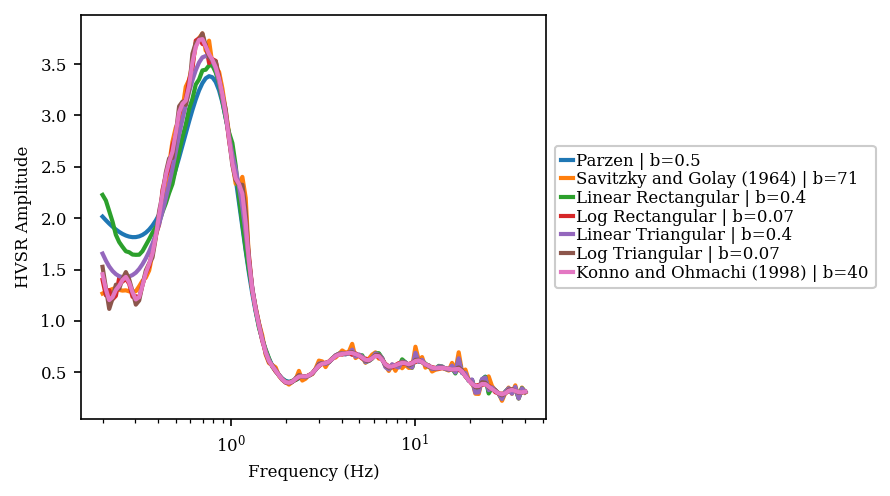

In [6]:
fig, ax = plt.subplots(figsize=(4,3.5), dpi=150)
for label, mean_curve in mean_curves.items():
    ax.plot(hvsr.frequency, mean_curve, label=label, lw=2)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("HVSR Amplitude")
ax.set_xscale("log")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()